In [1]:
#ИМПОРТ И ФУНКЦИИ С КЛАССАМИ
import h5py
import torch
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score

# выбираем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

# Класс датасета
class AudioDataset(Dataset):
    def __init__(self, h5_path):
        self.h5_path = h5_path
        self.file = h5py.File(h5_path, 'r')
        
        self.spectrograms = self.file['spectrograms']
        self.labels = self.file['labels']
        self.class_names = [name.decode('utf-8') for name in self.file.attrs['class_names']]
        self.num_classes = self.file.attrs['num_classes']
        
        print(f"Loaded {len(self.spectrograms)} samples from HDF5")
    
    def __len__(self):
        return len(self.spectrograms)
    
    def __getitem__(self, idx):
        # Загружаем непосредственно из HDF5
        spectrogram = torch.tensor(self.spectrograms[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return spectrogram, label
    
    def __del__(self):
        if hasattr(self, 'file'):
            self.file.close()
    
    def get_class_names(self):
        return self.class_names 
# Функция потерь (для теста)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()
# CNN + classifier    
class AudioCNN(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        
        super(AudioCNN, self).__init__()
        
        # CNN
        self.conv_layers = nn.Sequential(
            
            # Блок 1
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),    #[16, 64, 64]
            nn.Dropout(0.15),
            
            # Блок 2
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),    #[32, 32, 32]
            nn.Dropout(0.2),
            
            # Блок 3 
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),    #[64, 16, 16]
            nn.Dropout(0.25),

            # Блок 4
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3),

            nn.AdaptiveAvgPool2d((4,8)),    #[128, 4, 8]
        )

        # FC
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 8, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(1024, num_classes)
        )

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x
# AudioCNN + attention and only 512 neurons in classifier (1024 in AudioCNN)
class AudioCNN_2(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        super(AudioCNN_2, self).__init__()
        # CNN, вход - [1, 128, 256]
        self.conv_layers = nn.Sequential(
            
            # Блок 1
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=0), # [16, 124, 252] 
            nn.ELU(),
            nn.MaxPool2d(2), #[16, 62, 126]
            
            # Блок 2
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=0), #[32, 58, 122]
            nn.ELU(),
            nn.MaxPool2d(2), #[32, 29, 61]
            
            # Блок 3 
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=1), #[64, 26, 58]
            nn.ELU(),
            nn.MaxPool2d(2), #[64, 13, 29]

            # Блок 4
            nn.Conv2d(64, 64, kernel_size=4, stride=1, padding=0), #[64, 10, 26]
            nn.ELU(),
            
            # если вход [128, 512], то:
            #   1. [124, 508] - [62, 254]
            #   2. [58, 250] - [29, 125]
            #   3. [25, 121] - [26, 122] - [13,61]
        )

        # FC
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 10 * 26, 512),
            nn.ELU(),
            # nn.Dropout(0.5),

            nn.Linear(512, num_classes)
        )
    #     # инициализация весов
    #     self._initialize_weights()

    # def _initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Conv2d):
    #             nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    #             if m.bias is not None:
    #                 nn.init.constant_(m.bias, 0)
    #         elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
    #             nn.init.constant_(m.weight, 1)
    #             nn.init.constant_(m.bias, 0)
    #         elif isinstance(m, nn.Linear):
    #             nn.init.normal_(m.weight, 0, 0.01)
    #             nn.init.constant_(m.bias, 0)

    def forward(self, x):
        #CNN
        x = self.conv_layers(x)
        #FC
        x = self.classifier(x)
        return x

class AudioCNN_3(nn.Module):
    def __init__(self, num_classes, hidden_size=512):
        super(AudioCNN_3, self).__init__()
        # CNN, вход - [1, 128, 256]
        self.conv_1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=0), # [32, 124, 252] 
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.MaxPool2d(2), #[32, 62, 126]
            nn.Dropout(0.1),
        )

        self.conv_2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=0), # [64, 58, 122]
            nn.BatchNorm2d(64),
            nn.ELU(),
            nn.MaxPool2d(2), # [64, 29, 61]
            nn.Dropout(0.2),
        )

        self.conv_3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=1), # [128, 26, 58]
            nn.BatchNorm2d(128),
            nn.ELU(),
            nn.MaxPool2d(2), # [128, 13, 29]
            nn.Dropout(0.3),
        )

        self.conv_4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=5, stride=1, padding=0), # [256, 9, 25] 
            nn.BatchNorm2d(256),
            nn.ELU(),
            nn.Dropout(0.4),
        )
           
        self.avgpool = nn.Sequential(nn.AdaptiveAvgPool2d((1, 2))) #[256, 1, 2]

        # FC
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 1 * 2, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ELU(),
            nn.Dropout(0.5),

            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ELU(),
            nn.Dropout(0.5),

            nn.Linear(hidden_size // 2, num_classes)
        )    
    
    def forward(self, x):
        #CNN
        x = self.conv_1(x)
        x = self.conv_2(x)
        x = self.conv_3(x)
        x = self.conv_4(x)
        x = self.avgpool(x)
        #FC
        x = self.classifier(x)
        return x
# Полносвязная
class SimpleFCModel(nn.Module):
    def __init__(self, num_classes: int, input_height: int, input_width: int, hidden_size: int = 512):
        super(SimpleFCModel, self).__init__()
        
        self.input_height = input_height
        self.input_width = input_width
        self.num_classes = num_classes
        
        # Вычисляем размер после вытягивания в вектор
        self.flatten_size = input_height * input_width
        
        self.layers = nn.Sequential(
            # Вытягиваем в плоский вектор
            nn.Flatten(),
            
            # Первый скрытый слой
            nn.Linear(self.flatten_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),  # для регуляризации
            
            # Второй скрытый слой (можно добавить больше)
            nn.Linear(hidden_size, hidden_size // 2),
            nn.BatchNorm1d(hidden_size // 2),
            nn.ReLU(), 
            nn.Dropout(0.4),
            
            # Выходной слой
            nn.Linear(hidden_size // 2, num_classes)
        )
    
    def forward(self, x):
        x = self.layers(x)
        return x
# Загрузка модели
def load_checkpoint(model, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    
    history = checkpoint['history']
    epoches = checkpoint['epoch'] + 1
    best_f1 = checkpoint['best_f1']
    threshold = checkpoint.get('threshold', 0.5)
    
    print(f"Загружен чекпоинт эпохи {checkpoint['epoch']}")
    print(f"Лучший F1: {best_f1:.4f}")
    
    return model, history, epoches, best_f1, threshold
# Подсчёт метрик
def calculate_all_metrics(y_true, y_pred):
    
    metrics = {}

    # F1 Macro - баланс между классами (ОСНОВНАЯ)
    metrics['f1'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    # Precision Macro - контроль false positive
    metrics['precision'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    # Recall Macro - контроль false negative
    metrics['recall'] = recall_score(y_true, y_pred, average='macro', zero_division=0)

    # F1 для каждого класса
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    metrics['f1_per_class'] = f1_per_class
    
    return metrics
# Прогон через нейросеть
def evaluate_epoch(model, loader, threshold):
    model.eval()
    all_targets = []
    all_predictions = []
    all_probs = []
    
    with torch.no_grad():
        for data, targets in loader:  
            
            data = data.to(device)
            targets = targets.to(device) 

            outputs = model(data)                       

            probs = torch.sigmoid(outputs)   
            predictions = (probs > threshold).float()   
            
            all_targets.append(targets.cpu())          
            all_predictions.append(predictions.cpu())
            all_probs.append(probs.cpu())
    
    all_targets = torch.cat(all_targets).numpy()
    all_predictions = torch.cat(all_predictions).numpy()
    all_probs = torch.cat(all_probs)

    return calculate_all_metrics(all_targets, all_predictions)

def plot_training_history(history, save_path=None):
    
    fig = plt.figure(figsize=(15, 14))
    fig.suptitle('История тренировки', fontsize=16, fontweight='bold')
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    gs = plt.GridSpec(2, 2, figure=fig)

    # 1. Loss
    ax1 = fig.add_subplot(gs[0,0])
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. F1 Score
    ax2 = fig.add_subplot(gs[0,1])
    ax2.plot(epochs, history['train_f1'], 'b-', label='Train F1', linewidth=2)
    ax2.plot(epochs, history['val_f1'], 'r-', label='Val F1', linewidth=2)
    ax2.set_title('F1 Macro Score')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Precision
    ax3 = fig.add_subplot(gs[1,0])
    ax3.plot(epochs, history['train_precision'], 'b-', label='Train Precision', linewidth=2)
    ax3.plot(epochs, history['val_precision'], 'r-', label='Val Precision', linewidth=2)
    ax3.set_title('Precision Macro')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Precision')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    # 4. Recall
    ax4 = fig.add_subplot(gs[1,1])
    ax4.plot(epochs, history['train_recall'], 'b-', label='Train Recall', linewidth=2)
    ax4.plot(epochs, history['val_recall'], 'r-', label='Val Recall', linewidth=2)
    ax4.set_title('Recall Macro')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Recall')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Graphs saved to: {save_path}")
    
    plt.show()

In [2]:
# ЗАГРУЗКА ДАТАСЕТА
# ----------------------------------------------------------
test_dataset = AudioDataset("../data/datasets/128x256_test.h5")

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,  
    num_workers=2,   
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

for data, targets in test_loader:
    print(f"TEST DATA - shape: {data.shape}")
    print(f"    min: {data.min().item():.4f}, max: {data.max().item():.4f}")
    print(f"    mean: {data.mean().item():.4f}, std: {data.std().item():.4f}")
    break

Loaded 9175 samples from HDF5


TEST DATA - shape: torch.Size([64, 1, 128, 256])
    min: -13.8155, max: 11.4678
    mean: 1.1657, std: 4.1440


In [3]:
model = AudioCNN_3(test_dataset.num_classes)

load_path = "../data/models/CNN_3/best_model.pth"
model, history, epoches, best_f1, threshold = load_checkpoint(model, load_path, device)
model.to(device)
print(f"Количество эпох: {epoches} | Лучший F1-macro: {best_f1:.4f} | Порог: {threshold:.2f}\n")
# plot_training_history(history)

# Проверка на test данных (не учавстовали в обучении)
print("Метрики тестовой выборки не учавствующей в обучении: ")
test_metrics = evaluate_epoch(model, test_loader, threshold)
print(f"    F1: {test_metrics['f1']:.4f} | Precision: {test_metrics['precision']:.4f} | Recall: {test_metrics['recall']:.4f}\n")

Загружен чекпоинт эпохи 1
Лучший F1: 0.0218
Количество эпох: 2 | Лучший F1-macro: 0.0218 | Порог: 0.10

Метрики тестовой выборки не учавствующей в обучении: 
    F1: 0.0187 | Precision: 0.0278 | Recall: 0.0586



Загружен чекпоинт эпохи 1
Лучший F1: 0.0218
torch.Size([1, 128, 256])


/home/egr/projects/nmus/.venv/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/egr/projects/nmus/.venv/lib/python3.12/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3

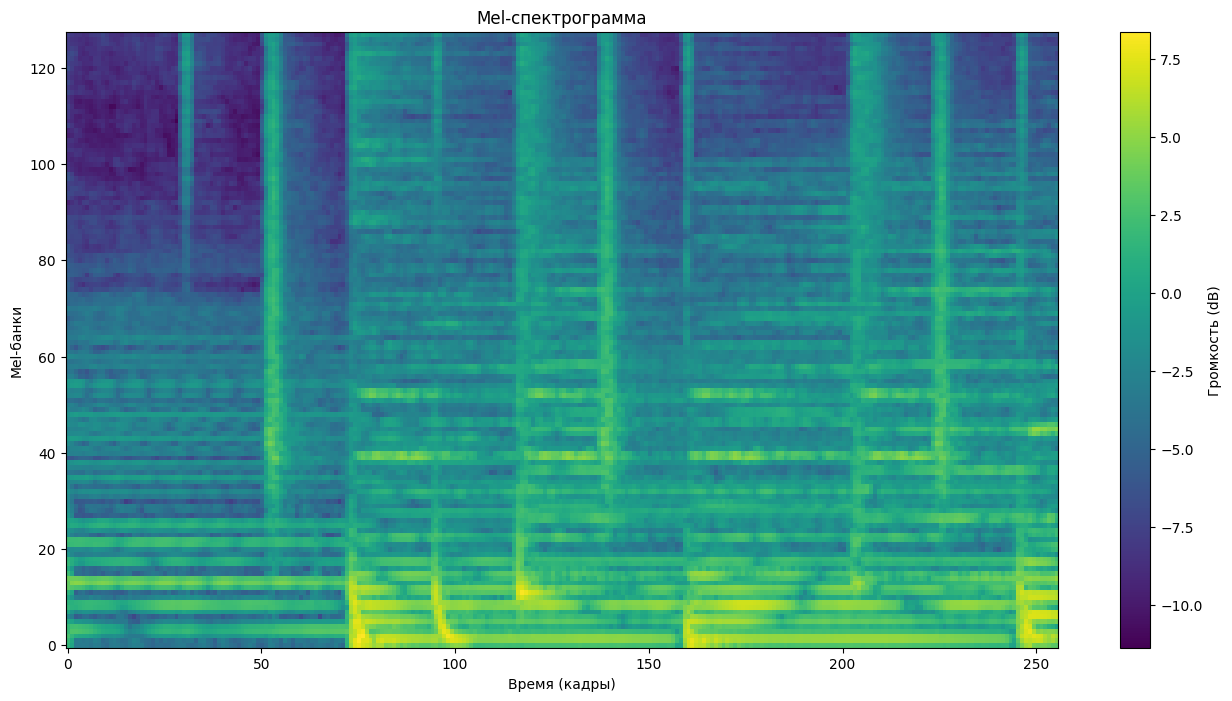

torch.Size([1, 1, 128, 256])


ValueError: Expected more than 1 value per channel when training, got input size torch.Size([1, 512])

In [4]:
import math
import torchaudio

def preprocess_audio(audio_path, target_sr = 22050) -> torch.Tensor:
    waveform, sr = torchaudio.load(audio_path, normalize=True, channels_first=True)
    #уменьшил частоту дискретизации, чтобы ещё меньше датасет весил, а то везде 44100 Гц или почти везде
    if sr != target_sr:
        waveform = torchaudio.functional.resample(waveform, sr, target_sr)
    
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=22050,
        n_mels=128,        
        n_fft=2048,       
        hop_length=512,
        f_min=20,
        f_max=8000
    )(waveform)

    mel_spectrogram = torch.log(mel_spectrogram + 1e-6)

    return mel_spectrogram[:,:,:]

def spektr_view(mel_spektr, w=16, h=8):
    plt.figure(figsize=(w, h))
    plt.imshow(mel_spektr[:,:], cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(label='Громкость (dB)')
    plt.title("Mel-спектрограмма")
    plt.xlabel("Время (кадры)")
    plt.ylabel("Mel-банки")
    plt.show()

def cnn_view(layers, cmap='viridis', max_cols=8, figsize_mult=2):
    num_layers = layers.shape[0]
    
    # Автоматически определяем размеры сетки
    cols = min(max_cols, num_layers)  # Не больше max_cols столбцов
    rows = math.ceil(num_layers / cols)  # Столько строк, сколько нужно
    
    # Рассчитываем размер фигуры
    fig_width = cols * figsize_mult
    fig_height = rows * figsize_mult * (layers.shape[1] / layers.shape[2]) if layers.shape[2] > 0 else rows * figsize_mult
    
    fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))
    
    # Преобразуем axes в плоский массив для удобства
    if rows == 1 and cols == 1:
        axes = np.array([axes])
    elif rows == 1 or cols == 1:
        axes = axes.flat
    else:
        axes = axes.flat
    
    for i in range(num_layers):
        # Нормализуем каждый слой для лучшей визуализации
        layer = layers[i]
        if layer.max() - layer.min() > 0:
            layer_norm = (layer - layer.min()) / (layer.max() - layer.min())
        else:
            layer_norm = layer
        
        axes[i].imshow(layer_norm, cmap=cmap, aspect='auto')
        axes[i].set_title(f'Слой {i}', fontsize=max(8, 12 - 0.1 * num_layers))
        axes[i].axis('off')
    
    # Скрываем пустые subplots
    for j in range(num_layers, len(axes)):
        axes[j].axis('off')
    
    plt.suptitle(f'CNN Layers Visualization ({num_layers} слоев)', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()

model = AudioCNN_3(59)
load_path = "../data/models/CNN_3/best_model.pth"
model, _, _, _, _ = load_checkpoint(model, load_path, device)
model.to(device)

# Препроцессинг
mel_spec = preprocess_audio("../data/train/00/7400.mp3")[:,:,:256]
print(mel_spec.shape)
spektr_view(mel_spec[0,:,:])

# Добавляем batch dimension и перемещаем на устройство
if len(mel_spec.shape) == 3:  # [channels, height, width]
    input_tensor = mel_spec.unsqueeze(0)  # [1, channels, height, width]
else:
    input_tensor = mel_spec.unsqueeze(0).unsqueeze(0)  # [1, 1, height, width]

input_tensor = input_tensor.to(device)


print(input_tensor.shape)

# Предсказание
with torch.no_grad():
    outputs = model(input_tensor)
    probs = torch.sigmoid(outputs).cpu().numpy()[0]

print(probs.shape)


cnn_view(probs)

